# Introduction

This part creates a new proxy-means test using a KNN algorithm on a testing sample drawn from the ENAHO. The MSE on the hold out sample are estimated and compared with the hold-out MSE from the Hanna and Olken model.

# Data

First, we import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import matplotlib.lines as mlines
import statsmodels.api as sm
import statistics

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from stargazer.stargazer import Stargazer

Next, we read in the dataset and save it in the data variable. We also take a look at its shape to confirm that everything was loaded correctly.

In [2]:
# Read in the data
data = pd.read_csv('C:/Users/mauro/OneDrive/Dokumente/Mauro/Universität Zürich/Master/HS20/Machine Learning for Economic Analysis/Project 1/data_preprocessed.csv')
# Get the shape of the data
data.shape

(22674, 65)

We set the display option to show all rows and all columns.

In [3]:
# Set the display option to show all rows and all columns of the dataset
pd.options.display.max_rows = None
pd.options.display.max_columns = None

We can take a look at the head of the data and the data types.

In [4]:
# Check data head
data.head()
# Check data
data.dtypes

lnpercapitaconsumption     float64
d_fuel_wood                  int64
d_fuel_coal                  int64
d_fuel_kerosene              int64
d_fuel_gas                   int64
d_fuel_electric              int64
d_fuel_none                  int64
d_water_river                int64
d_water_well                 int64
d_water_truck                int64
d_water_pylon                int64
d_water_outside              int64
d_water_inside               int64
d_drain_none                 int64
d_drain_river                int64
d_drain_cesspool             int64
d_drain_septic               int64
d_drain_outside              int64
d_drain_inside               int64
d_wall_woodmat             float64
d_wall_stonemud            float64
d_wall_quincha             float64
d_wall_tapia               float64
d_wall_adobe               float64
d_wall_stonecement         float64
d_wall_brickcement         float64
d_roof_straw               float64
d_roof_mat                 float64
d_roof_platecane    

# KNN Regression

We set per capita consumption as the dependent variable and the rest of the columns as the explanatory variables.

In [5]:
X = data.drop(['lnpercapitaconsumption'],axis=1)
y = data['lnpercapitaconsumption']

In order to get a functional model, we need to find the optimal number of neighbors for the KNN approach. To ensure that the data generation process is robuste, we use a 10-fold cross-validation. The different K's are evalauterd using the mean squared error of the individual model.

In [6]:
k_range = range(1, 31)
k_scores10 = []

for k in k_range:
    regressor = KNeighborsRegressor(n_neighbors = k)
    scores = cross_val_score(regressor, X, y, cv=10, scoring='neg_mean_squared_error')
    k_scores10.append(scores.mean())

Afterwards, we can print the plot comparing the MSE and the values of K.

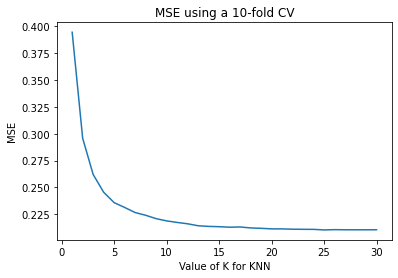

In [7]:
plt.plot(k_range, np.array(k_scores10) *-1)
plt.title("MSE using a 10-fold CV")
plt.xlabel('Value of K for KNN')
plt.ylabel('MSE')
plt.show()

To get more robust models, we can repeat this step for a 7- and 5-fold cross validation. 

In [8]:
k_scores7 = []

for k in k_range:
    regressor = KNeighborsRegressor(n_neighbors = k)
    scores = cross_val_score(regressor, X, y, cv=7, scoring='neg_mean_squared_error')
    k_scores7.append(scores.mean())

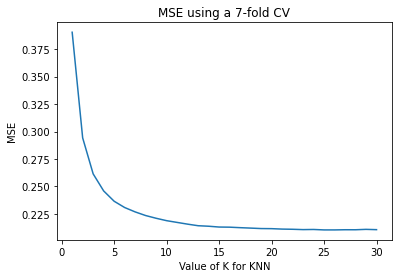

In [9]:
plt.plot(k_range, np.array(k_scores7) *-1)
plt.title("MSE using a 7-fold CV")
plt.xlabel('Value of K for KNN')
plt.ylabel('MSE')
plt.show()

In [10]:
k_scores5 = []

for k in k_range:
    regressor = KNeighborsRegressor(n_neighbors = k)
    scores = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_squared_error')
    k_scores5.append(scores.mean())

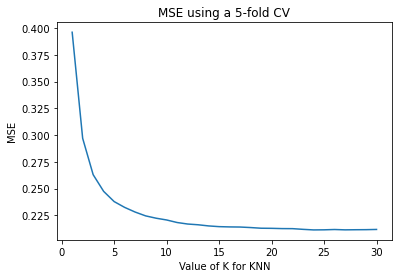

In [11]:
plt.plot(k_range, np.array(k_scores5) *-1)
plt.title("MSE using a 5-fold CV")
plt.xlabel('Value of K for KNN')
plt.ylabel('MSE')
plt.show()

The average of the three attained optimal gives us the optimal number of neighbors in the model of 25. We will use this specification to test other parameters.

We will now test different options for the distance weighting.

In [12]:
regressor = KNeighborsRegressor(n_neighbors = 25, weights='uniform')
score = cross_val_score(regressor, X, y, cv=10, scoring='neg_mean_squared_error')
print(np.mean(score))

-0.2103921016932314


In [13]:
regressor = KNeighborsRegressor(n_neighbors = 25, weights='distance')
score_dist = cross_val_score(regressor, X, y, cv=10, scoring='neg_mean_squared_error')
print(np.mean(score_dist))

-0.23747002256043376


Using a 10-fold CV we see that the uniform distance weighting yields the lowest average MSE.

Next, we can test different distance metrics:

In [14]:
#Manhattan distance
regressor = KNeighborsRegressor(n_neighbors = 25, p=1)
score_p1 = cross_val_score(regressor, X, y, cv=10, scoring='neg_mean_squared_error')
print(np.mean(score_p1))

-0.2103921016932314


In [15]:
#Euclidean distance 
regressor = KNeighborsRegressor(n_neighbors = 25, p=2)
score_p2 = cross_val_score(regressor, X, y, cv=10, scoring='neg_mean_squared_error')
print(np.mean(score_p2))

-0.2103921016932314


In [16]:
#Minkowski distance with power 3
regressor = KNeighborsRegressor(n_neighbors = 25, p=3)
score_p3 = cross_val_score(regressor, X, y, cv=10, scoring='neg_mean_squared_error')
print(np.mean(score_p3))

-0.2103921016932314


The distance metric does not improve the MSE and we therefore will go on with the standard Euclidean distance function.

We can now combine the optimal parameters obtained from the selection process and apply the KNN to the entire training dataset of 22’674 observations

In [17]:
regressor = KNeighborsRegressor(n_neighbors = 25, weights='uniform', algorithm='auto', p=2, metric='minkowski')
regressor.fit(X, y)
y_pred = regressor.predict(X)
print(sklearn.metrics.mean_squared_error(y, y_pred))


0.19366543340678455


Furthermore, we can plot the predictions against the actual values:

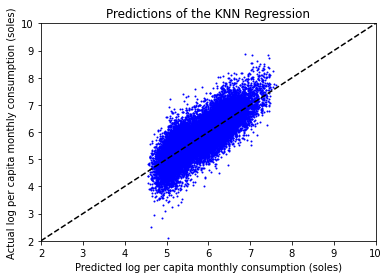

In [18]:
x, y = y_pred, y
fig, ax = plt.subplots()
ax.scatter(x, y, c='blue', s = 1)
line = mlines.Line2D([0, 1], [0, 1], color='black', linestyle='dashed')
plt.title("Predictions of the KNN Regression")
ax.set_xlabel('Predicted log per capita monthly consumption (soles)')
ax.set_ylabel('Actual log per capita monthly consumption (soles)')
axes = plt.gca()
axes.set_xlim([2,10])
axes.set_ylim([2,10])
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.show()

# Inclusion Error and Exclusion Error

In this section, we assume a cutoff approximately at the 28th percentile.

We can than create the ROC curve for the KNN model.

In [19]:
cons = np.array(data.lnpercapitaconsumption)
p = np.percentile(cons, 28) 

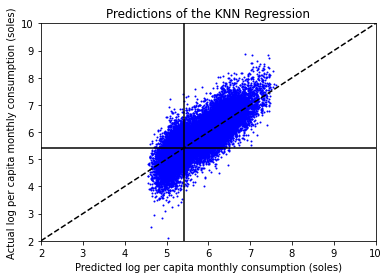

In [20]:
x, y = y_pred, y
fig, ax = plt.subplots()
ax.scatter(x, y, c='blue', s = 1)
line = mlines.Line2D([0, 1], [0, 1], color='black', linestyle='dashed')
ax.axhline(y=p, color='black')
ax.axvline(x=p, color='black')
plt.title("Predictions of the KNN Regression")
ax.set_xlabel('Predicted log per capita monthly consumption (soles)')
ax.set_ylabel('Actual log per capita monthly consumption (soles)')
axes = plt.gca()
axes.set_xlim([2,10])
axes.set_ylim([2,10])
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.show()

In [21]:
dat = np.array(y_pred)
dat2 = np.array(y)
df = pd.DataFrame({'Predicted_values':dat, 'Actual_values':dat2})

# Calcualte the inclusion and exclusion error for thresholds equal to the percentiles ranging from 1 to 100
incl_error = []
one_minus_excl_error = []
cutoff = []

Ks = 100

for i in np.arange(1,Ks, 0.01): 
    
    cons = np.array(data.lnpercapitaconsumption)
    p = np.percentile(cons, i) 
    
    FP = df[(df['Predicted_values'] < p) & (df['Actual_values'] > p)].count()
    TN_FP = df[df['Actual_values'] > p].count()
    FP_ratio = FP / TN_FP
    inclusion_error = FP_ratio
    
    FN = df[(df['Predicted_values'] > p) & (df['Actual_values'] < p)].count()
    TP_FN = df[df['Actual_values'] < p].count()
    TP_ratio = FN / TP_FN
    one_minus_exclusion_error = 1 - TP_ratio
    
    incl_error.append(inclusion_error)
    one_minus_excl_error.append(one_minus_exclusion_error)
    cutoff.append(p)

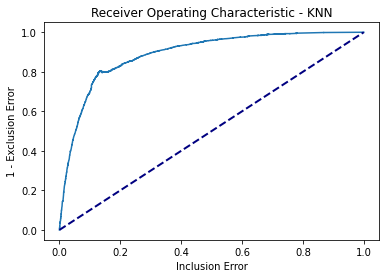

In [22]:
# Plot the ROC curve
incl_error = np.array(incl_error)
excl_error = np.array(one_minus_excl_error)

df1 = pd.DataFrame(incl_error, columns = ["inclusion_error", "false"])
df1 = df1.drop(['false'], axis=1)
df2 = pd.DataFrame(excl_error, columns = ["inclusion_error", "false"])
df2 = df2.drop(['false'], axis = 1)

lw = 2
plt.plot(df1, df2)
plt.xlabel('Inclusion Error')
plt.ylabel('1 - Exclusion Error')
plt.title('Receiver Operating Characteristic - KNN')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

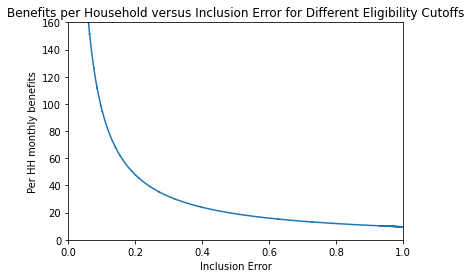

In [23]:
df2["eligible_hh"] = 274000/(df2*28710)
df2["cutoff_value"] = cutoff
df2 = df2.iloc[60:,]


plt.plot(df2.inclusion_error, df2.eligible_hh)
plt.xlabel('Inclusion Error')
plt.ylabel('Per HH monthly benefits')
plt.title('Benefits per Household versus Inclusion Error for Different Eligibility Cutoffs')
plt.axis([0,1, 0, 160])
plt.show()

# Predictions on testdata

## Data Preprocessing

In [24]:
data_test = pd.read_csv('C:/Users/mauro/OneDrive/Dokumente/Mauro/Universität Zürich/Master/HS20/Machine Learning for Economic Analysis/Project 1/peru_matlab_export_full.csv')

In [25]:
data_test = data_test.loc[data_test['training'] == 0]

In [26]:
data_test = data_test.drop(columns=['percapitaconsumption','d_fuel_other','d_water_other','d_wall_other','d_roof_other','d_floor_other','d_insurance_0','d_crowd_lessthan1','d_lux_0','training','poor','h_hhsize','id_for_matlab','hhid','lncaphat_OLS','percapitahat_OLS'])

In [27]:
data_test.dropna(axis=0,inplace=True)

In [28]:
data_test.shape

(22704, 65)

In [29]:
data_test.head()

lnpercapitaconsumption  d_fuel_wood  d_fuel_coal  d_fuel_kerosene  \
0                5.351858            1            0                0   
1                5.768755            0            0                0   
2                5.968277            0            0                0   
3                5.654599            0            0                0   
4                4.771289            1            0                0   

   d_fuel_gas  d_fuel_electric  d_fuel_none  d_water_river  d_water_well  \
0           0                0            0              1             0   
1           1                0            0              0             0   
2           1                0            0              0             0   
3           1                0            0              0             0   
4           0                0            0              1             0   

   d_water_truck  d_water_pylon  d_water_outside  d_water_inside  \
0              0              0                0               0   
1              0              0                0               1   
2              0              0                0               1   
3              0              0                0               1   
4              0              0                0               0   

   d_drain_none  d_drain_river  d_drain_cesspool  d_drain_septic  \
0             1              0                 0               0   
1             0              0                 1               0   
2             0              0                 0               0   
3             0              0                 0               0   
4             0              0                 1               0   

   d_drain_outside  d_drain_inside  d_wall_woodmat  d_wall_stonemud  \
0                0               0             0.0              0.0   
1                0               0             0.0              0.0   
2                0               1             0.0              0.0   
3                0               1             0.0              0.0   
4                0               0             0.0              0.0   

   d_wall_quincha  d_wall_tapia  d_wall_adobe  d_wall_stonecement  \
0             0.0           0.0           0.0                 0.0   
1             1.0           0.0           0.0                 0.0   
2             0.0           0.0           0.0                 0.0   
3             0.0           0.0           0.0                 0.0   
4             0.0           0.0           1.0                 0.0   

   d_wall_brickcement  d_roof_straw  d_roof_mat  d_roof_platecane  \
0                 0.0           1.0         0.0               0.0   
1                 0.0           0.0         0.0               1.0   
2                 1.0           0.0         0.0               1.0   
3                 1.0           0.0         0.0               0.0   
4                 0.0           0.0         0.0               0.0   

   d_roof_tile  d_roof_wood  d_roof_concrete  d_floor_earth  d_floor_cement  \
0          0.0          0.0              0.0            0.0             0.0   
1          0.0          0.0              0.0            1.0             0.0   
2          0.0          0.0              0.0            0.0             1.0   
3          0.0          0.0              1.0            0.0             0.0   
4          1.0          0.0              0.0            1.0             0.0   

   d_floor_wood  d_floor_tile  d_floor_sheets  d_floor_parquet  d_electricity  \
0           0.0           0.0             0.0              0.0              0   
1           0.0           0.0             0.0              0.0              1   
2           0.0           0.0             0.0              0.0              1   
3           0.0           1.0             0.0              0.0              1   
4           0.0           0.0             0.0              0.0              0   

   d_telephone  d_h_educ_none  d_h_educ_pre  d_h_educ_prim  d_h_educ_sec  \


In [30]:
data_test.tail()

lnpercapitaconsumption  d_fuel_wood  d_fuel_coal  d_fuel_kerosene  \
23147                4.414663            1            0                0   
23148                4.872012            0            0                0   
23149                5.213170            1            0                0   
23150                7.829582            0            0                0   
23151                5.912096            0            0                0   

       d_fuel_gas  d_fuel_electric  d_fuel_none  d_water_river  d_water_well  \
23147           0                0            0              1             0   
23148           0                0            0              0             1   
23149           0                0            0              0             1   
23150           1                0            0              0             0   
23151           1                0            0              0             0   

       d_water_truck  d_water_pylon  d_water_outside  d_water_inside  \
23147              0              0                0               0   
23148              0              0                0               0   
23149              0              0                0               0   
23150              0              0                0               1   
23151              0              0                0               1   

       d_drain_none  d_drain_river  d_drain_cesspool  d_drain_septic  \
23147             1              0                 0               0   
23148             0              0                 1               0   
23149             0              1                 0               0   
23150             0              0                 0               0   
23151             0              0                 0               0   

       d_drain_outside  d_drain_inside  d_wall_woodmat  d_wall_stonemud  \
23147                0               0             0.0              0.0   
23148                0               0             0.0              0.0   
23149                0               0             0.0              0.0   
23150                0               1             0.0              0.0   
23151                0               1             0.0              0.0   

       d_wall_quincha  d_wall_tapia  d_wall_adobe  d_wall_stonecement  \
23147             0.0           0.0           0.0                 0.0   
23148             0.0           1.0           0.0                 0.0   
23149             0.0           0.0           0.0                 0.0   
23150             0.0           0.0           1.0                 0.0   
23151             0.0           0.0           0.0                 0.0   

       d_wall_brickcement  d_roof_straw  d_roof_mat  d_roof_platecane  \
23147                 0.0           1.0         0.0               0.0   
23148                 0.0           0.0         0.0               0.0   
23149                 0.0           0.0         0.0               0.0   
23150                 0.0           0.0         0.0               0.0   
23151                 0.0           0.0         0.0               1.0   

       d_roof_tile  d_roof_wood  d_roof_concrete  d_floor_earth  \
23147          0.0          0.0              0.0            0.0   
23148          1.0          0.0              0.0            1.0   
23149          1.0          0.0              0.0            1.0   
23150          0.0          0.0              1.0            0.0   
23151          0.0          0.0              0.0            1.0   

       d_floor_cement  d_floor_wood  d_floor_tile  d_floor_sheets  \
23147             0.0           0.0           0.0             0.0   
23148             0.0           0.0           0.0             0.0   
23149             0.0           0.0           0.0             0.0   
23150             1.0           0.0           0.0             0.0   
23151             0.0           0.0           0.0             0.0   

       d_floor_parquet  d_electricity  d_telephone  d_h_

## Predictions (Test)

In [31]:
X_test = data_test.drop(['lnpercapitaconsumption'],axis=1)
y_test = data_test['lnpercapitaconsumption']

In [32]:
regressor = KNeighborsRegressor(n_neighbors = 25, weights='uniform', algorithm='auto', p=2, metric='minkowski')
regressor.fit(X_test, y_test)
y_test_pred = regressor.predict(X_test)
print(sklearn.metrics.mean_squared_error(y_test, y_test_pred))

0.19251185720419003


In [34]:
pd.DataFrame(y_test_pred).to_csv(r'C:/Users/mauro/OneDrive/Dokumente/Mauro/Universität Zürich/Master/HS20/Machine Learning for Economic Analysis/Project 1/predictions.csv', index = False, header=True)